In [1]:
# Predicting california housing prices

# Steps


The eight main steps

- Frame the problem and look at the big picture
- Get the data
- Explore the data to gain insights
- Prepare the data to better expose the underlying data patterns to  Machine Learning Algorithms
- Explore many different models and short-list the best ones
- Fine-tune your models and combine them into a great solution
- Present your solution
- Launch, monitor and maintain your system.

In [2]:
from six.moves import urllib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy  as np
import hashlib
import tarfile
import os

In [3]:
# Constants


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH  = "datasets/housing"
HOUSING_URL   = DOWNLOAD_ROOT + HOUSING_PATH+'/housing.tgz'


In [4]:
# Download the dataset

def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    
    tgz_path = os.path.join(housing_path,'housing.tgz')        
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tarfile = tarfile.open(tgz_path)
    housing_tarfile.extractall(housing_path)
    housing_tarfile.close()
    
fetch_housing_data()

In [5]:

#helper functions


# load the dataset into pandas dataframe
def load_dataset_into_frame():
    dataset_location = os.path.join(HOUSING_PATH,'housing.csv')
    return pd.read_csv(dataset_location)



In [6]:
# main function
housing = load_dataset_into_frame()

In [7]:
# Gain insights about the data

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Notes

- Standard Deviation measures how dispersed the values are 
- 25%,50%,75% rows shows the corresponding **percentiles***
   
     - For instance, 25% of the districts have a housing_median_age lower than 18.
     - 50% of the districts have a housing_median_age lower than 29
     - 75% of the districts have a housing_median_age lower than 37 
     


*percentiles - indicates the value below which a given percentage of observations in a group of observations falls.

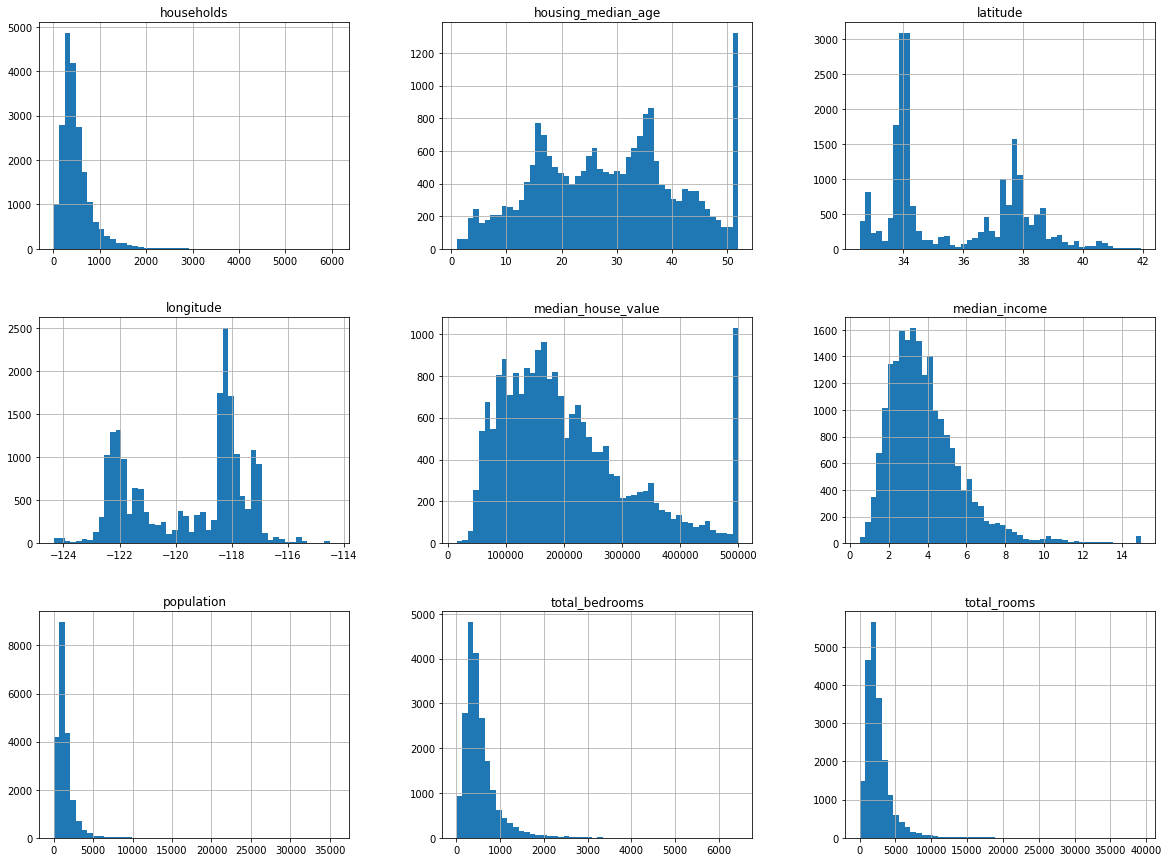

In [9]:
# plotting each attribute
housing.hist(bins=50,figsize=(20,15))
plt.show()

# Create a test set

In [10]:
# to make this notebook's output identical at every run

def split_train_test(data,test_set_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(test_set_ratio * len(data))    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]
    

In [11]:
train_data,test_data = split_train_test(housing,0.2)

In [12]:
len(train_data)

16512

In [13]:
len(test_data)

4128

In [14]:


def test_set_check(identifier,test_set_ratio,hash_fn):
    return hash_fn(np.int64(identifier)).digest()[-1] < 256 * test_set_ratio
    

def split_test_set_by_hash(data,test_set_ratio,id_column,hash_fn=hashlib.md5):
    indices = data[id_column]
    test_set_booleans = indices.apply(lambda index:test_set_check(index,test_set_ratio,hash_fn))
    return data[~test_set_booleans],data[test_set_booleans]

In [15]:
train_set_hash,test_set_hash = split_test_set_by_hash(housing.reset_index(),0.2,'index')

In [16]:
len(train_set_hash)

16362

In [17]:
len(test_set_hash)

4278

In [18]:
# Test set should respresent various categories of income in the whole dataset.
housing['income_category'] = np.ceil(housing['median_income'] / 1.5)
housing['income_category'].where(housing['income_category'] < 5,5.0,inplace=True)


In [19]:
# use stratififed shuffle split

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing['income_category']):
    stratified_train_set = housing.loc[train_index]
    stratified_test_set  = housing.loc[test_index]

In [20]:
len(stratified_train_set)

16512

In [21]:
len(stratified_test_set)

4128

In [22]:
# drop the column
for set_ in (stratified_train_set,stratified_test_set):
    set_.drop('income_category',axis=1,inplace=True)

In [23]:
train_housing = stratified_train_set.copy()
test_housing = stratified_test_set.copy()

In [24]:
train_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [25]:
train_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


In [26]:
train_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


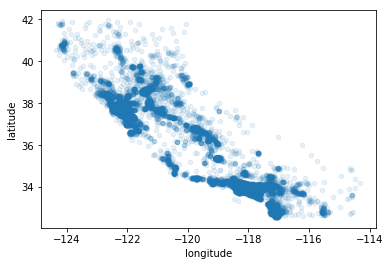

In [27]:
# Discover and visualize the data to gain insights

train_housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)


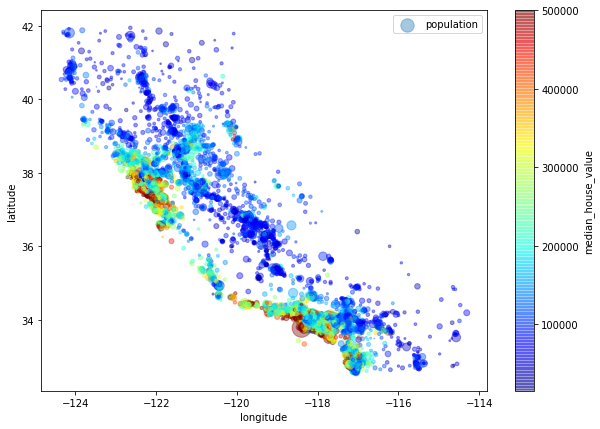

In [28]:
# Let me put some colors

# s - The radius of each circle represents districts population
# c - The color represents the price of the house (option c)
# cmap - predefined color map (option cmap)

train_housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
                   s=housing['population']/100,label='population',
                   figsize=(10,7),c='median_house_value',
                   cmap=plt.get_cmap('jet'),
                   colorbar=True,sharex=False)

plt.legend()

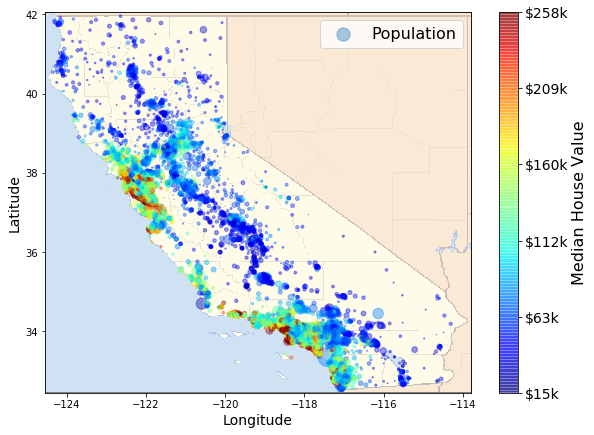

In [29]:
# More more pretty
import matplotlib.image as mpimg

california_img = mpimg.imread('../pictures/map.png')

ax = train_housing.plot(kind='scatter',x='longitude',y='latitude',
                        s = train_housing['population']/100,
                        c ='median_house_value',
                        cmap=plt.get_cmap('jet'),
                        figsize=(10,7),
                        label='Population',
                        colorbar=False,
                        alpha=0.4               
                 )

plt.imshow(california_img,extent=[-124.55,-113.80,32.45,42.05],
           alpha=0.5,cmap=plt.get_cmap('jet'))
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(),prices.max(),11)

cbar = plt.colorbar()
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values],fontsize=14)
cbar.set_label('Median House Value',fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [30]:
train_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 2.0+ MB


In [31]:
# What other features that are highly correlated to median_house_value

correlation = train_housing.corr()
correlation['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


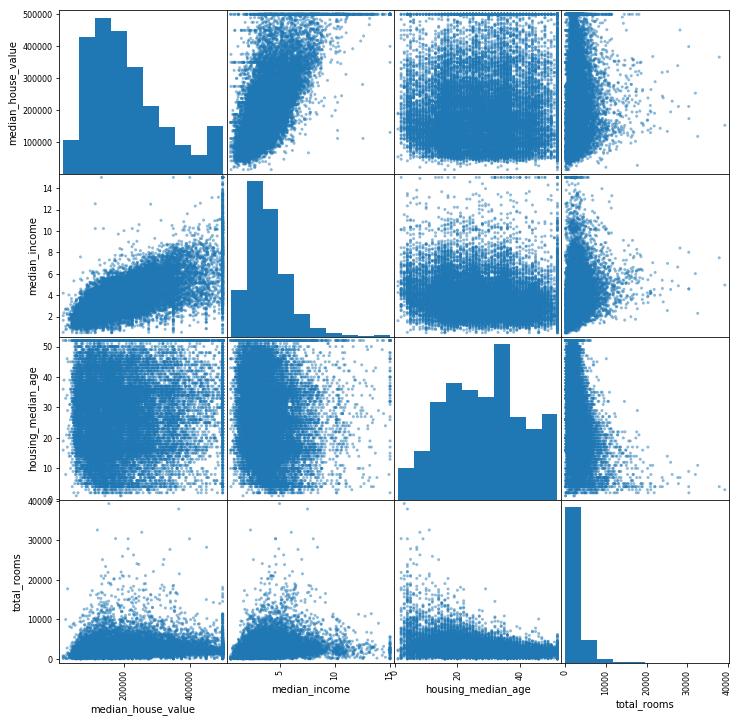

In [32]:
# The correlation coefficient ranges from -1 and 1. 

# When it is close to 1,
# it means that there is a strong positive correlation.

# For example, 

# 1.The median_house_value tends to go up,when the median_income goes up.
# 

# When it is close to -1, it means that there is a strong negative 
# correlation

# For example
# 
# You see there is a strong negative correlation 
# between median_house_value and median_income


# When it is close to zero, means that there is no linear correlation


from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value','median_income',
              'housing_median_age','total_rooms']

scatter_matrix(housing[attributes],figsize=(12,12))
plt.show()



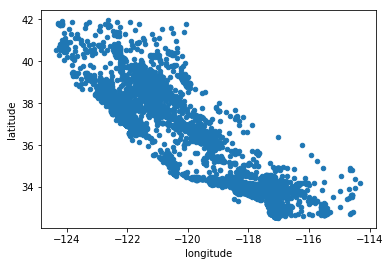

In [33]:
train_housing.plot(kind='scatter',x='longitude',y='latitude')

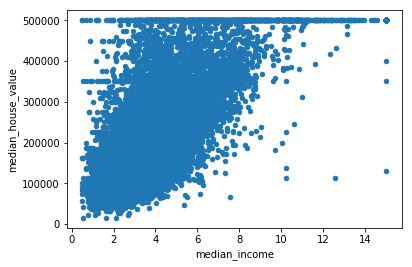

In [34]:
train_housing.plot(kind='scatter',x='median_income',y='median_house_value')

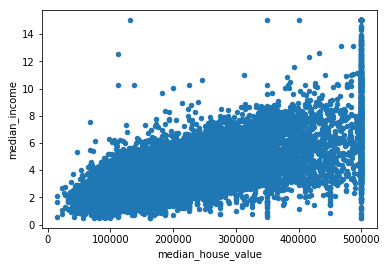

In [35]:
train_housing.plot(kind='scatter',x='median_house_value',y='median_income')

In [36]:
train_housing['rooms_per_household']=train_housing['total_rooms']/train_housing['households']
train_housing['bedrooms_per_household']=train_housing['total_bedrooms']/train_housing['households'] 

train_housing['population_per_household']=train_housing['population']/train_housing['households']



In [37]:
correlation = train_housing.corr()

In [38]:
correlation['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
bedrooms_per_household     -0.043343
longitude                  -0.047432
latitude                   -0.142724
Name: median_house_value, dtype: float64

In [39]:
housing = stratified_train_set.drop("median_house_value",axis=1)
housing_labels = stratified_train_set["median_house_value"].copy()

In [40]:
# Data cleaning

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
housing_without_categorical = housing.drop("ocean_proximity",axis=1)

imputer.fit(housing_without_categorical)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [41]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [42]:
x = imputer.transform(housing_without_categorical)

In [43]:
pFrame = pd.DataFrame(x,columns=housing_without_categorical.columns)

In [44]:
pFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
encoder = LabelEncoder()
housing_categorical = housing["ocean_proximity"]
housing_categorical_encoded = encoder.fit_transform(housing_categorical)

In [47]:
housing_categorical_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [48]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [49]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
encoder = OneHotEncoder()
housing_categorical_binary = encoder.fit_transform(housing_categorical_encoded.reshape(1,-1))

In [51]:
housing_categorical_binary.toarray()

array([[1., 1., 1., ..., 1., 1., 1.]])

In [52]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_categorical_OneHot = encoder.fit_transform(housing_categorical)
housing_categorical_OneHot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [53]:
# Custom Transformers

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix,bedrooms_ix,population_ix,household_ix = 3,4,5,6


class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        bedrooms_per_household = X[:,bedrooms_ix] / X[:,household_ix]
        population_per_household = X[:,population_ix] / X[:,household_ix]
        
        if self.add_bedrooms_per_room:
            return np.c_[X,rooms_per_household,bedrooms_per_household,population_per_household] 
        return np.c_[X,rooms_per_household,population_per_household]

        
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
attr_adder.transform(housing.values)
    
    

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 1.0353982300884956,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 0.9557522123893806,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 1.0194805194805194,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 1.1398692810457516,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 1.0674157303370786,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.0672926447574336,
        1.9859154929577465]], dtype=object)

In [54]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.9+ MB


In [55]:

rooms_ix,bedrooms_ix,population_ix,household_ix = 3,4,5,6
X = housing.values 

In [56]:
X[:,rooms_ix] / X[:,household_ix]

array([4.625368731563422, 6.008849557522124, 4.225108225108225, ...,
       6.34640522875817, 5.50561797752809, 4.843505477308295],
      dtype=object)

In [57]:
type(housing.values)

numpy.ndarray

In [58]:
type(housing)

pandas.core.frame.DataFrame

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attributes_pipeline = Pipeline([
    ('imputer',Imputer(strategy='median')),
    ('attribs_header',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
])


num_attributes_pipeline.fit_transform(housing.drop('ocean_proximity',axis=1)).shape


(16512, 11)

**Notes**

It would be good if we could feed a pandas Dataframe directly into our pipleline instead of having to first manually extract the numerical columns into a NumPy Array

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,attribute_names=None):
        self.attribute_names = attribute_names
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X[self.attribute_names].values    

In [61]:
num_attributes = list(housing_without_categorical.columns)

In [62]:
cat_attributes = housing_categorical.name

In [63]:
num_attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [64]:
num_attributes_pipeline = Pipeline([
    ('Selector',DataFrameSelector(num_attributes)),
    ('imputer',Imputer(strategy='median')),
    ('attribs_header',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
])

In [65]:
num_attributes_pipeline.fit_transform(housing_without_categorical)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.1215581 , -0.08649871],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.26453207, -0.03353391],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.15013227, -0.09240499],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
         0.06597972, -0.03055414],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
        -0.06408293,  0.06150916],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.06430388, -0.09586294]])

In [66]:
from categoricalencoder import CategoricalEncoder


categorical_attribute_pipeline = Pipeline([
    ('Selector',DataFrameSelector([cat_attributes])),
    ('categorical',CategoricalEncoder())
])

In [67]:
categorical_attribute_pipeline.fit_transform(housing)

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [68]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_attributes_pipeline),
    ('category_pipeline',categorical_attribute_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [69]:
housing[[cat_attributes]].values.shape

(16512, 1)

In [70]:
# Machine Learning Predictions

In [71]:
# Linear regression

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(housing_prepared,housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [72]:
some_data = housing.iloc[:5]

In [73]:
some_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 17606 to 3555
Data columns (total 9 columns):
longitude             5 non-null float64
latitude              5 non-null float64
housing_median_age    5 non-null float64
total_rooms           5 non-null float64
total_bedrooms        5 non-null float64
population            5 non-null float64
households            5 non-null float64
median_income         5 non-null float64
ocean_proximity       5 non-null object
dtypes: float64(8), object(1)
memory usage: 400.0+ bytes


In [74]:
some_labels = housing_labels.iloc[:5]

In [75]:
preprocessed_data = full_pipeline.transform(some_data)

In [76]:
preprocessed_data

<5x16 sparse matrix of type '<class 'numpy.float64'>'
	with 60 stored elements in Compressed Sparse Row format>

In [77]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.9+ MB


In [78]:
predicted_labels = linreg.predict(preprocessed_data)

In [79]:
from sklearn.metrics import mean_squared_error

In [80]:
error = mean_squared_error(some_labels,predicted_labels)

In [81]:
root_mean_square = np.sqrt(error)

In [82]:
root_mean_square

44643.070785718715

In [83]:
predictions = linreg.predict(housing_prepared)

In [84]:
error = mean_squared_error(housing_labels,predictions)

In [85]:
error

4748794332.762985

In [86]:
np.sqrt(error)

68911.49637588045

In [87]:
predicted_labels

array([211881.21792188, 321219.24229225, 210877.63066046,  62198.25497432,
       194847.84152086])

In [88]:
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [89]:
predictions

array([211881.21792188, 321219.24229225, 210877.63066046, ...,
        96767.67430078, 217494.64846138, 277572.73274812])

In [90]:
# Train more complex model

from sklearn.tree import DecisionTreeRegressor

decisionTR = DecisionTreeRegressor()
decisionTR.fit(housing_prepared,housing_labels)
predicitions = decisionTR.predict(housing_prepared)
error = mean_squared_error(housing_labels, predicitions)
rmse = np.sqrt(error)

In [91]:
error # Overfitting

0.0

# Cross Validation

In [92]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(decisionTR,
                         housing_prepared,
                         housing_labels,
                         scoring="neg_mean_squared_error",
                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [93]:
# Display the scores

In [94]:
def display_scores(scores):
    print('Scores:',len(scores))
    print('Mean:',scores.mean())
    print('Standard deviation',scores.std())

display_scores(tree_rmse_scores)

Scores: 10
Mean: 71784.43801100385
Standard deviation 3360.9060091008673


In [95]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(linreg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv = 10)

In [96]:
scores = np.sqrt(-scores)

display_scores(scores)

Scores: 10
Mean: 69302.41894436616
Standard deviation 2653.4607022369887


In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
forest_regression = RandomForestRegressor()
forest_regression.fit(housing_prepared,housing_labels)


scores = cross_val_score(forest_regression,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)

scores = np.sqrt(-scores)
display_scores(scores)

Scores: 10
Mean: 53050.733909826806
Standard deviation 2246.4607544824703


In [99]:
predictions = forest_regression.predict(housing_prepared)
error = mean_squared_error(housing_labels,predicitions)
rmse = np.sqrt(-error)

In [100]:
rmse

-0.0

In [101]:
from sklearn.svm import SVR

svr_reg = SVR(kernel="linear")
svr_reg.fit(housing_prepared,housing_labels)
predictions = svr_reg.predict(housing_prepared)
error = mean_squared_error(housing_labels,predictions)
error

12448287651.963419

In [102]:
scores = cross_val_score(svr_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
scores = np.sqrt(-scores)
display_scores(scores)

Scores: 10
Mean: 112227.80000532458
Standard deviation 2797.160705682055


# Grid Search


In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

In [109]:

# Load data
iris = load_iris()
X = iris.data
y = iris.target


logistic = LogisticRegression()

# Create regularization penalty space
penalty = ['l1','l2']

# Create a regularization hyperparameter space
C = np.logspace(0,4,10)

#Create hyperparameter options
hyperparameters = dict(C=C,penalty=penalty)

clf = GridSearchCV(logistic,hyperparameters,cv=5,verbose=0)

best_model = clf.fit(X,y)

# view the best parameters
print('Best Penalty', best_model.best_estimator_.get_params()['penalty'])
print('Best C',best_model.best_estimator_.get_params()['C'])


Best Penalty l1
Best C 7.742636826811269


In [111]:
# randomforest regression using gridsearchcv

from sklearn.ensemble import RandomForestRegressor

forest_regressor = RandomForestRegressor()

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]

grid_search = GridSearchCV(forest_regressor,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1)
grid_search.fit(housing_prepared,housing_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [117]:
grid_search.best_estimator_.get_params()['n_estimators']

30

In [118]:
grid_search.best_estimator_.get_params()['max_features']

6

In [120]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [121]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [129]:
cvres = grid_search.cv_results_

In [132]:
for test_score,params in zip(cvres['mean_test_score'],cvres['params']):
    print('{0} {1}'.format(np.sqrt(-test_score),params))

64311.419501851175 {'n_estimators': 3, 'max_features': 2}
56534.39769980657 {'n_estimators': 10, 'max_features': 2}
53065.32151297693 {'n_estimators': 30, 'max_features': 2}
59283.39904568885 {'n_estimators': 3, 'max_features': 4}
52535.98236336029 {'n_estimators': 10, 'max_features': 4}
50590.536142446 {'n_estimators': 30, 'max_features': 4}
59360.39645960344 {'n_estimators': 3, 'max_features': 6}
51689.194116910556 {'n_estimators': 10, 'max_features': 6}
49719.34180511301 {'n_estimators': 30, 'max_features': 6}
57515.54115166343 {'n_estimators': 3, 'max_features': 8}
52359.13146339037 {'n_estimators': 10, 'max_features': 8}
50107.025246247154 {'n_estimators': 30, 'max_features': 8}
63019.43078295648 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
54571.53908778642 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
60221.62948153169 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
52513.24050670934 {'bootstrap': False, 'n_estimators': 10, 'max_features': 

In [137]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

forestRegressor = RandomForestRegressor(random_state=42)

param_distributions = {
    'n_estimators':randint(low=1,high=200),
    'max_features':randint(low=1,high=8)
}


random_search = RandomizedSearchCV(forestRegressor,
                   param_distributions=param_distributions,
                   n_iter=10,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   random_state=42
                  )

random_search.fit(housing_prepared,housing_labels)



RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7ef0251e48>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7ef0251d30>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

# Ensemble methods